# **Experiment 5: Extra Tree**

__Steps:__

1. Load datasets and create functions
2. Data splitting
3. Cross-validation with default hyperparameters
4. Reduce Overfitting with n_estimators
5. Reduce Overfitting with max_depth
6. Reduce Overfitting with min_samples_leaf
7. Reduce Overfitting with max_features
8. Auto tuning using Random Search
9. Assess the best RandomForest Model on testing set
10. Feature importance

## **1. Load datasets and create functions** 

**[1.1]** Import packages

In [1]:
import pandas as pd
import math 
import numpy as np
from itertools import repeat

# train test split
from sklearn.model_selection import train_test_split

# performance metrics
from sklearn.metrics import fbeta_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# visualization 
import matplotlib.pyplot as plt
import altair as alt
alt.data_transformers.disable_max_rows()

# cross validate 
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

from scipy.stats import randint

# classifier 
from sklearn.ensemble import ExtraTreesClassifier

**[1.2]** Load the training dataset into dataframe called df_data

In [2]:
df_data = pd.read_csv('./repurchase_data-prepared.csv')

**[1.3]** Load the training dataset into dataframe called df_test

In [3]:
df_test = pd.read_csv('./repurchase_test-prepared.csv')

**[1.4]** Create a function to summarize cross-validation results of tested hyperparameter values

In [4]:
def summarize_cv_hyperparameter(cv_scores, hyperparam_name, hyperparam_values):
    """
    Parameters:
        cv_scores (nd array): average cross-validation scores of tested hyperparameter values. 
        hyperparam_name: name of the hyperparameter (e.g. n_estimators)
        hyperparam_value (1d array): different values of the hyperparameter (e.g. [10, 50, 100])
    Return:
        A Dataframe that contains 4 columns:
        - hyperparam_name: the hyperparameter value
        - recall_score: average cross-validation recall of a given hyperparameter value on a given set.
        - dataset: the type of dataset on which recall_score is calculated. Either train or test.
        - overfitting: the difference between train_score and test_score 
    """
    recall_scores = []
    n_hyperparam_values = len(hyperparam_values)
    dataset = ['train', 'test'] * n_hyperparam_values
    overfitting = []
    
    # loop through average cross-validation scores of each hyperparameter value
    for item in cv_scores:
        recall_scores.append(item['train_score'])
        recall_scores.append(item['test_score'])
        overfitting.extend(repeat(item['train_score'] - item['test_score'],2))
    return pd.DataFrame({hyperparam_name: sorted(hyperparam_values * 2), 'recall_score': recall_scores, 'dataset': dataset, 'overfitting': overfitting})

**[1.5]** Create a function to plot train scores vs test scores of different hyperparameter values to see bias-variance trade-off

In [5]:
def compare_train_test(summary, hyperparam_name):
    return alt.Chart(summary).mark_line(point=True).encode(
        x=hyperparam_name,
        y='recall_score',
        color='dataset',
    )

## 2. Data Splitting

**[2.1]** Extract target values and independent values from df_data

In [6]:
y_data = df_data.pop('Target')
X_data = df_data

**[2.2]** Extract target values and independent values from df_test

In [7]:
y_test = df_test.pop('Target')
X_test = df_test

**[2.3]** Instantiate a StratifiedKFold with 3 splits

In [8]:
skf = StratifiedKFold(n_splits=3, shuffle = True, random_state = 8)
cv = list(skf.split(X_data, y_data))    

## 3. Train Initial Extra Tree with Default Hyperparameters

**[3.1]** Fit the ExtraTreesClassifier model and calculate scores for all cv

In [9]:
scores_default = cross_validate(ExtraTreesClassifier(random_state=8), X_data, y_data, cv=cv, scoring='recall', return_train_score=True)

**[3.2]** Average scores of all cv

In [10]:
avg_scores_default = {metric:np.mean(scores) for (metric, scores) in scores_default.items()}
avg_scores_default

{'fit_time': 3.8063694636027017,
 'score_time': 0.484403133392334,
 'test_score': 0.6112886048988285,
 'train_score': 0.9994675186368477}

**[3.3]** Overfitting

In [11]:
overfitting = avg_scores_default['train_score'] - avg_scores_default['test_score']
overfitting

0.38817891373801916

## 4. Reduce Overfitting with n_estimators

**[4.1]** Train a ExtraTreesClassifier model with n_estimators=[25, 50, 100, 200] and print the recall scores for the training and validation sets

In [12]:
scores_n_estimators = []
n_estimators = [25, 50, 100, 200]
for v in n_estimators:
    et = ExtraTreesClassifier(random_state=8, n_estimators=v)
    scores_tuned = cross_validate(et, X_data, y_data, cv=cv, scoring='recall', return_train_score=True)
    avg_scores_tuned = {metric:np.mean(scores) for (metric, scores) in scores_tuned.items()}
    scores_n_estimators.append(avg_scores_tuned)
scores_n_estimators

[{'fit_time': 0.997957706451416,
  'score_time': 0.14139548937479654,
  'test_score': 0.6017039403620873,
  'train_score': 0.9994675186368477},
 {'fit_time': 1.8841686248779297,
  'score_time': 0.24692034721374512,
  'test_score': 0.6020589279375222,
  'train_score': 0.9994675186368477},
 {'fit_time': 3.9610063234965005,
  'score_time': 0.4999868869781494,
  'test_score': 0.6112886048988285,
  'train_score': 0.9994675186368477},
 {'fit_time': 7.906224727630615,
  'score_time': 0.995368480682373,
  'test_score': 0.6155484558040468,
  'train_score': 0.9994675186368477}]

**[4.2]** Plot cross-validation recall scores across all n_estimators 

In [13]:
n_estimators_summary= summarize_cv_hyperparameter(scores_n_estimators, 'n_estimators', n_estimators)
n_estimators_summary

,n_estimators,recall_score,dataset,overfitting
0,25,0.999468,train,0.397764
1,25,0.601704,test,0.397764
2,50,0.999468,train,0.397409
3,50,0.602059,test,0.397409
4,100,0.999468,train,0.388179
5,100,0.611289,test,0.388179
6,200,0.999468,train,0.383919
7,200,0.615548,test,0.383919


In [14]:
compare_train_test(n_estimators_summary, 'n_estimators')

alt.Chart(...)

### _Conclusion_:

The graph shows that neither an increase or decrease in n_estimators affects the performance and the level of overfitting. Moreover, larger n_estimators is more computationally expensive. Hence, for the next steps, I decided to use n_estimators = 50 instead of the default 100 because recall (test) will increase and overfitting will decrease.

## 5. Reduce Overfitting with max_depth

**[5.1]** Train model with n_estimators = 50

In [15]:
et1 = ExtraTreesClassifier(random_state=8, n_estimators=50).fit(X_data, y_data)

**[5.2]** Print the average "**max_depth**" for et1:

In [16]:
np.mean([estimator.tree_.max_depth for estimator in et1.estimators_])

35.42

**[5.3]** Train a ExtraTreesClassifier model with n_estimators=50, max_depth = [15, 20, 35, 40, 60] and print the recall scores for the training and validation sets

In [17]:
scores_max_depth = []
max_depths = [15, 20, 35, 40, 60]
for v in max_depths:
    et = ExtraTreesClassifier(random_state=8, n_estimators=50, max_depth=v)
    scores_tuned = cross_validate(et, X_data, y_data, cv=cv, scoring='recall', return_train_score=True)
    avg_scores_tuned = {metric:np.mean(scores) for (metric, scores) in scores_tuned.items()}
    scores_max_depth.append(avg_scores_tuned)
scores_max_depth

[{'fit_time': 1.6964062849680583,
  'score_time': 0.21442810694376627,
  'test_score': 0.4224352147674831,
  'train_score': 0.6957756478523253},
 {'fit_time': 1.8693026701609294,
  'score_time': 0.23667168617248535,
  'test_score': 0.5761448349307775,
  'train_score': 0.9762158324458644},
 {'fit_time': 1.9459679921468098,
  'score_time': 0.26002732912699383,
  'test_score': 0.6045438409655662,
  'train_score': 0.9994675186368477},
 {'fit_time': 1.920734961827596,
  'score_time': 0.2525704701741536,
  'test_score': 0.6013489527866525,
  'train_score': 0.9994675186368477},
 {'fit_time': 1.90788729985555,
  'score_time': 0.2517682711283366,
  'test_score': 0.6020589279375222,
  'train_score': 0.9994675186368477}]

**[5.4]** Plot cross-validation recall scores across all max_depth 

In [18]:
max_depth_summary= summarize_cv_hyperparameter(scores_max_depth, 'max_depth', max_depths)
max_depth_summary

,max_depth,recall_score,dataset,overfitting
0,15,0.695776,train,0.273340
1,15,0.422435,test,0.273340
2,20,0.976216,train,0.400071
3,20,0.576145,test,0.400071
4,35,0.999468,train,0.394924
5,35,0.604544,test,0.394924
6,40,0.999468,train,0.398119
7,40,0.601349,test,0.398119
8,60,0.999468,train,0.397409
9,60,0.602059,test,0.397409


In [19]:
compare_train_test(max_depth_summary, 'max_depth')

alt.Chart(...)

### _Conclusion_:

In the above graph, max_depth above 35 do not differ in level of overfitting and has better performance. Meanwhile, there is a sign of underfitting when max_depth is less than 20. Therefore, __35 <= max_depth <= 40__ is the best range of max_depth because the overfitting is acceptable while performance is still preserved. 

Hence, for the next steps, I decided to use max_depth = 35 because overfitting decreases while performance is maintained.

## 6. Reduce Overfitting with min_samples_leaf

**[6.1]** Train a ExtraTreesClassifier model with n_estimators=50, max_depth = 35, min_samples_leaf = [2, 5, 10, 20] and print the recall scores for the training and validation sets

In [20]:
scores_min_samples_leaf = []
min_samples_leafs = [2, 5, 10, 20]
for v in min_samples_leafs:
    et = ExtraTreesClassifier(random_state=8, n_estimators=50, max_depth=35, min_samples_leaf=v)
    scores_tuned = cross_validate(et, X_data, y_data, cv=cv, scoring='recall', return_train_score=True)
    avg_scores_tuned = {metric:np.mean(scores) for (metric, scores) in scores_tuned.items()}
    scores_min_samples_leaf.append(avg_scores_tuned)
scores_min_samples_leaf

[{'fit_time': 1.844580094019572,
  'score_time': 0.23601595560709634,
  'test_score': 0.5410010649627264,
  'train_score': 0.8887113951011715},
 {'fit_time': 1.7845473289489746,
  'score_time': 0.23730866114298502,
  'test_score': 0.40113596024139153,
  'train_score': 0.5395811146609869},
 {'fit_time': 1.7788807551066081,
  'score_time': 0.20739436149597168,
  'test_score': 0.281150159744409,
  'train_score': 0.3580049698260561},
 {'fit_time': 1.6460277239481609,
  'score_time': 0.18899997075398764,
  'test_score': 0.1700390486332978,
  'train_score': 0.19701810436634717}]

**[6.2]** Plot cross-validation recall scores across all min_samples_leaf

In [21]:
min_samples_leaf_summary= summarize_cv_hyperparameter(scores_min_samples_leaf, 'min_samples_leaf', min_samples_leafs)
min_samples_leaf_summary

,min_samples_leaf,recall_score,dataset,overfitting
0,2,0.888711,train,0.347710
1,2,0.541001,test,0.347710
2,5,0.539581,train,0.138445
3,5,0.401136,test,0.138445
4,10,0.358005,train,0.076855
5,10,0.281150,test,0.076855
6,20,0.197018,train,0.026979
7,20,0.170039,test,0.026979


In [22]:
compare_train_test(min_samples_leaf_summary, 'min_samples_leaf')

alt.Chart(...)

### _Conclusion_:

In the above graph, the larger the min_samples_leaf is, the less the overfitting is, but the lower the performance is.

Hence, for the next steps, I decided to use the default min_samples_leaf = 2 because other min_samples_leaf decrease the performance significantly.

## 7.   Reduce Overfitting with max_features

**[7.1]** Train a ExtraTreesClassifier model with n_estimators=50, max_depth = 35, max_features = [6, 12, 24 ,29] print the recall scores for the training and validation sets

In [23]:
scores_max_feature = []
max_features = [2, 6, 12, 29]
for v in max_features:
    et = ExtraTreesClassifier(random_state=8, n_estimators=50, max_depth=35, max_features=v)
    scores_tuned = cross_validate(et, X_data, y_data, cv=cv, scoring='recall', return_train_score=True)
    avg_scores_tuned = {metric:np.mean(scores) for (metric, scores) in scores_tuned.items()}
    scores_max_feature.append(avg_scores_tuned)
scores_max_feature

[{'fit_time': 1.3246755599975586,
  'score_time': 0.2969084580739339,
  'test_score': 0.3943911963081292,
  'train_score': 0.9994675186368477},
 {'fit_time': 2.226779063542684,
  'score_time': 0.24504995346069336,
  'test_score': 0.6400425985090522,
  'train_score': 0.9994675186368477},
 {'fit_time': 3.4179913997650146,
  'score_time': 0.20983401934305826,
  'test_score': 0.7451189208377706,
  'train_score': 0.9994675186368477},
 {'fit_time': 7.556605418523152,
  'score_time': 0.19238789876302084,
  'test_score': 0.7852325168619099,
  'train_score': 0.9994675186368477}]

**[7.2]** Plot cross-validation recall scores across all max_features

In [24]:
max_feature_summary= summarize_cv_hyperparameter(scores_max_feature, 'max_feature', max_features)
max_feature_summary

,max_feature,recall_score,dataset,overfitting
0,2,0.999468,train,0.605076
1,2,0.394391,test,0.605076
2,6,0.999468,train,0.359425
3,6,0.640043,test,0.359425
4,12,0.999468,train,0.254349
5,12,0.745119,test,0.254349
6,29,0.999468,train,0.214235
7,29,0.785233,test,0.214235


In [25]:
compare_train_test(max_feature_summary, 'max_feature')

alt.Chart(...)

### _Conclusion_:

In the above graph, it can be seen that __22 <= max_feature <= 29__ is the best range because the overfitting is reduced while performance is still preserved. When max_feature is less than this range, it becomes more and more overfitting.

## 8. Auto tuning using  Random Search 

**[8.1]** Create a dictionary containing the hyperparameters value randomly

In [26]:
hyperparams_dist = {
    'n_estimators': randint(10, 50),
    'max_depth': randint(35, 40),
    'max_features': randint(22, 29)
    }
hyperparams_dist

{'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen at 0x7fe0e2112c10>,
 'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen at 0x7fe0dc9af7c0>,
 'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen at 0x7fe0e21128b0>}

**[8.2]** Instantiate a RandomSearchCV with the hyperparameter_dist and the extra tree model

In [27]:
random_search_et = RandomizedSearchCV(ExtraTreesClassifier(random_state=8), hyperparams_dist, cv=cv, verbose=1, n_iter=30, scoring = 'recall', random_state = 8)

**[8.3]** Fit the RandomizedSearchCV on the training set

In [28]:
random_search_et.fit(X_data, y_data)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomizedSearchCV(cv=[(array([     0,      1,      2, ..., 105064, 105065, 105068]),
                        array([     3,      5,      9, ..., 105063, 105066, 105067])),
                       (array([     0,      2,      3, ..., 105066, 105067, 105068]),
                        array([     1,      4,      6, ..., 105057, 105060, 105064])),
                       (array([     1,      3,      4, ..., 105064, 105066, 105067]),
                        array([     0,      2,      7, ..., 105061, 105065, 105068]))],
                   estimator=ExtraTreesClassifier(random_state=8), n_iter=30,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fe0dc9af7c0>,
                                        'max_features': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fe0e21128b0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7fe0e2112

**[8.4]** Display the best set of hyperparameters

In [29]:
best_params = random_search_et.best_params_
best_params

{'max_depth': 39, 'max_features': 25, 'n_estimators': 35}

**[8.5]** Display best recall

In [30]:
random_search_et.best_score_

0.7944621938232163

**[8.6]** Cross validate the best extra trees

In [31]:
best_random_search_et = cross_validate(ExtraTreesClassifier(random_state=8, n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], max_features=best_params['max_features']), X_data, y_data, cv=cv, scoring='recall', return_train_score=True)

**[8.7]** Average scores of all cv

In [32]:
avg_scores_best_random_search_et = {metric:np.mean(scores) for (metric, scores) in best_random_search_et.items()}
avg_scores_best_random_search_et

{'fit_time': 4.548611958821614,
 'score_time': 0.1403797467549642,
 'test_score': 0.7944621938232163,
 'train_score': 0.9994675186368477}

In [33]:
overfitting = avg_scores_best_random_search_et['train_score'] - avg_scores_best_random_search_et['test_score']
overfitting

0.20500532481363143

## 9. Assess the best RandomForest Model on testing set

**[9.1]** Train ExtraTree model with best set of hyper parameters

In [34]:
et_best = ExtraTreesClassifier(random_state=8, n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], max_features=best_params['max_features']).fit(X_data, y_data)

**[9.2]** Use the best ExtraTree model to predict X_test and save to y_test_preds

In [35]:
y_test_preds = et_best.predict(X_test)

**[9.3]** Print f2 score, precision, and recall on testing set

In [36]:
precision = precision_score(y_test, y_test_preds)
print('Precision: ', precision)
recall= recall_score(y_test, y_test_preds)
print('Recall: ', recall)
f2 = fbeta_score(y_test, y_test_preds, beta = 2)
print('F2: ', f2)

Precision:  0.9154704944178629
Recall:  0.8153409090909091
F2:  0.8335753703165844


**[9.4]** Confusion matrix on testing set

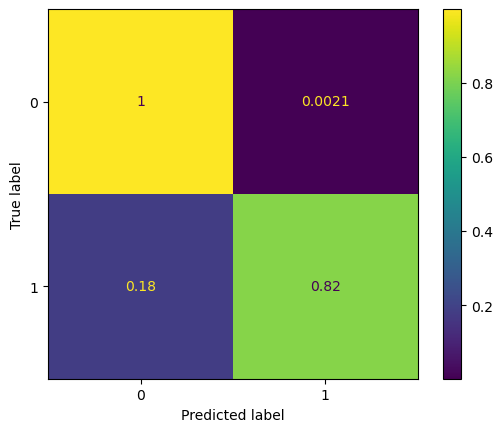

In [37]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_preds, normalize = 'true')

## 10. Feature importance 

**[10.1]** Print the features importance of et_best

In [38]:
et_best.feature_importances_

array([0.08353226, 0.06724198, 0.06874261, 0.0471942 , 0.0370193 ,
       0.04095455, 0.12010614, 0.16258366, 0.12019231, 0.06165744,
       0.12498173, 0.00345496, 0.00464404, 0.00018175, 0.00407604,
       0.00480939, 0.00270579, 0.00554698, 0.00033495, 0.00142167,
       0.00683934, 0.00785684, 0.00428259, 0.00602445, 0.00187961,
       0.00397243, 0.00486975, 0.0006639 , 0.00222936])

**[10.2]** Create a Dataframe with these values

In [39]:
feat_imp_et_df = pd.DataFrame(
    {
        'feature': X_data.columns,
     'feature_importance': et_best.feature_importances_
     }
)

In [40]:
feat_imp_et_df

,feature,feature_importance
0,age_of_vehicle_years,0.083532
1,sched_serv_warr,0.067242
2,non_sched_serv_warr,0.068743
3,sched_serv_paid,0.047194
4,non_sched_serv_paid,0.037019
5,total_paid_services,0.040955
6,total_services,0.120106
7,mth_since_last_serv,0.162584
8,annualised_mileage,0.120192
9,num_dealers_visited,0.061657


**[10.3]** Sort the previous dataframe and reset its index

In [41]:
feat_imp_et_df = feat_imp_et_df.sort_values('feature_importance', ascending=False).reset_index(drop=True)

**[10.4]** We can visualise this information on a graph

In [42]:
alt.Chart(feat_imp_et_df).mark_bar().encode(
    x='feature_importance',
    y=alt.Y("feature", sort='-x'),
    tooltip=['feature','feature_importance'])

alt.Chart(...)